# DVA263 project

# Libraries

Declaring all libraries in use

In [25]:
import autoencoder as ae

import cnn as cnn
import preprocessing as pre
import visualization as viz
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Load Dataset

In [26]:
def load(image_size):
    train_path = "../dataset/Project/train/"
    test_path = "../dataset/Project/test/"
    
    X_train, y_train = pre.get_dataset(train_path, image_size)
    X_test, y_test = pre.get_dataset(test_path, image_size)
    
    return X_train, y_train, X_test, y_test

# Prepare Data

In [27]:
import numpy as np


def prep_ae(train, test):
    return ae.preprocess_images(train)

def prep_cnn(X_train, y_train, X_test):
    """Add noise images to train and test set and normalize"""
    # Apply noise augmentation on train data
    g_noisy_train = pre.add_gaussian_noise(X_train)
    snp_noisy_train = pre.add_salt_and_pepper_noise(X_train)

    # Stack the original and noisy images together
    X_train_combined = np.concatenate((X_train, g_noisy_train, snp_noisy_train), axis=0)
    y_train_combined = np.concatenate((y_train, y_train, y_train), axis=0)  # Duplicate labels accordingly

    # Normalize datasets
    X_train_norm = pre.normalize_images(X_train_combined)
    X_test_norm = pre.normalize_images(X_test)

    return X_train_norm, y_train_combined, X_test_norm

# Build and Compile Models

In [28]:
def build_ae():
    model = ae.build_and_compile()
    return model
def build_cnn():
    model = cnn.build_cnn_model()
    return model

#  Train Models

In [29]:
def train_ae(model, ae_train):
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_delta=0.0005)
    early_stop = EarlyStopping(monitor="val_loss", patience=5, min_delta=0.0002, restore_best_weights=True)
    callbacks = [reduce_lr, early_stop]

    history = ae.fit_model(ae, ae_train, epochs=30, batch_size=32, callbacks=callbacks)
    return history

def train_cnn(model,cnn_train, cnn_test):
    history = cnn.train_model(model, cnn_train, cnn_test)
    return history

# Plotting Training and Validation Figures

In [30]:
def visualize_training_history(ae_history, cnn_history):
    viz.plot_metrics(ae_history, "Autoencoder", accuracy=False)
    viz.plot_metrics(cnn_history, "CNN", accuracy=True)

# Putting everything together

Main section putting each part together and running the classification task

## Import and preprocess data

In [31]:
image_size = (152, 152)

X_train, y_train, X_test, y_test = load(image_size)

Found 259 files belonging to 4 classes.
Found 33 files belonging to 4 classes.


### Get 

## Train autoencoder

## Calculate threshold for anomaly detection procedure

## Train CNN model

In [33]:
# Load dataset
X_train, y_train, X_test, y_test = load((152, 152))

# Preprocess dataset (add noise + normalize)
X_train, y_train, X_test = prep_cnn(X_train, y_train, X_test)

print(type(X_train), type(y_train))
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

# Build and train the CNN model
CNN_model = build_cnn()
CNN_history = train_cnn(CNN_model, X_train, y_train)

# Predict on test set

Found 259 files belonging to 4 classes.
Found 33 files belonging to 4 classes.
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(777, 152, 152, 3) (777, 4)
(33, 152, 152, 3) (33, 4)
Epoch 1/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7908 - loss: 0.9206 - val_accuracy: 0.8462 - val_loss: 0.5966 - learning_rate: 0.0010
Epoch 2/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7983 - loss: 0.7315 - val_accuracy: 0.8462 - val_loss: 0.6776 - learning_rate: 0.0010
Epoch 3/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - accuracy: 0.7821 - loss: 0.7613 - val_accuracy: 0.8462 - val_loss: 0.6046 - learning_rate: 0.0010
Epoch 4/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7888 - loss: 0.7204 - val_accuracy: 0.8462 - val_loss: 0.6633 - learning_rate: 0.0010
Epoch 5/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.7904 - loss: 0.6720 - val_accuracy: 0.8462 - val_loss: 0.6248 - learning_rate: 2.0000e-04
Epoch 6/70
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accurac

In [22]:
predictions = CNN_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


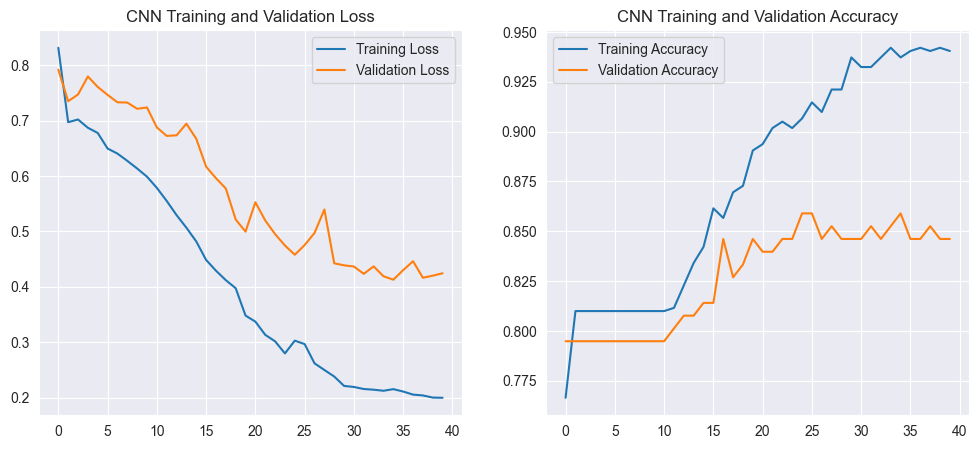

In [23]:
viz.plot_metrics(CNN_history, "CNN", accuracy=True)

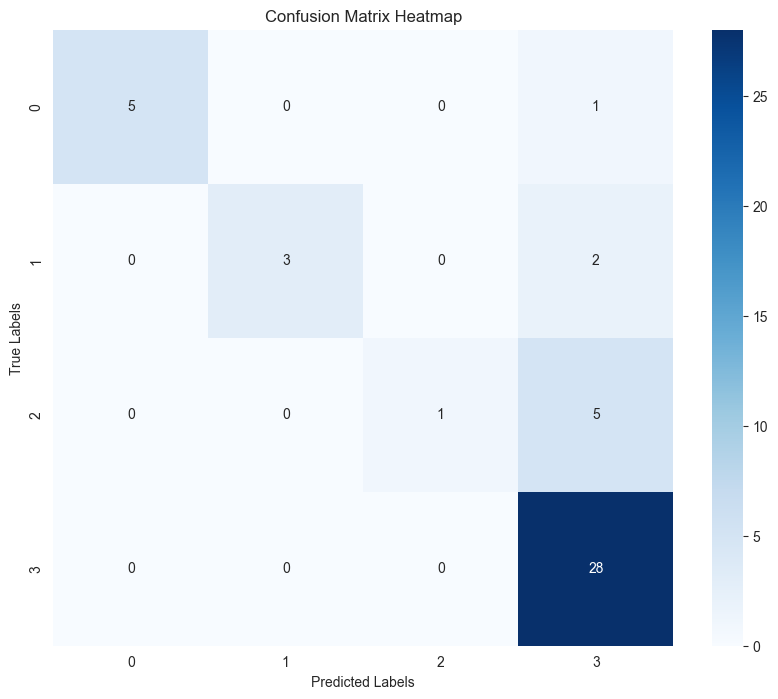

In [24]:
viz.plot_heatmap(y_test, predictions)

In [35]:

from collections import Counter

y_train_flat = np.argmax(y_train, axis=1) if y_train.ndim > 1 else y_train
y_test_flat = np.argmax(y_test, axis=1) if y_test.ndim > 1 else y_test

train_class_counts = Counter(y_train_flat)
test_class_counts = Counter(y_test_flat)

print("Training dataset class distribution:")
print(train_class_counts)

print("Test dataset class distribution:")
print(test_class_counts)


Training dataset class distribution:
Counter({3: 627, 2: 51, 1: 51, 0: 48})
Test dataset class distribution:
Counter({3: 20, 1: 5, 0: 4, 2: 4})
